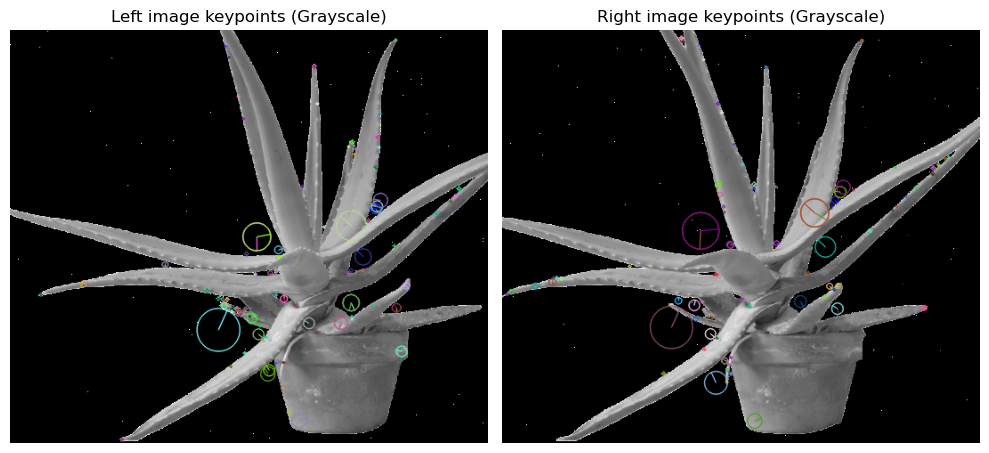

In [59]:
import cv2
import matplotlib.pyplot as plt

# 1. Load the images
img1 = cv2.imread('aloeL.jpg')
img2 = cv2.imread('aloeR.jpg')

# 2. Convert to grayscale for SIFT detection
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 3. Create SIFT detector
sift = cv2.SIFT_create()

# 4. Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# 5. Keep TOP 100 keypoints (by response)
kp1_top = sorted(kp1, key=lambda x: -x.response)[:100]
kp2_top = sorted(kp2, key=lambda x: -x.response)[:100]

# 6. Draw keypoints on grayscale images only
img1_kp_gray = cv2.drawKeypoints(gray1, kp1_top, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp_gray = cv2.drawKeypoints(gray2, kp2_top, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# 7. Save grayscale keypoint images
cv2.imwrite('img1_keypoints_gray.jpg', img1_kp_gray)
cv2.imwrite('img2_keypoints_gray.jpg', img2_kp_gray)

# 8. Display grayscale keypoints using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Left image keypoints (Grayscale)')
plt.imshow(img1_kp_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Right image keypoints (Grayscale)')
plt.imshow(img2_kp_gray, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


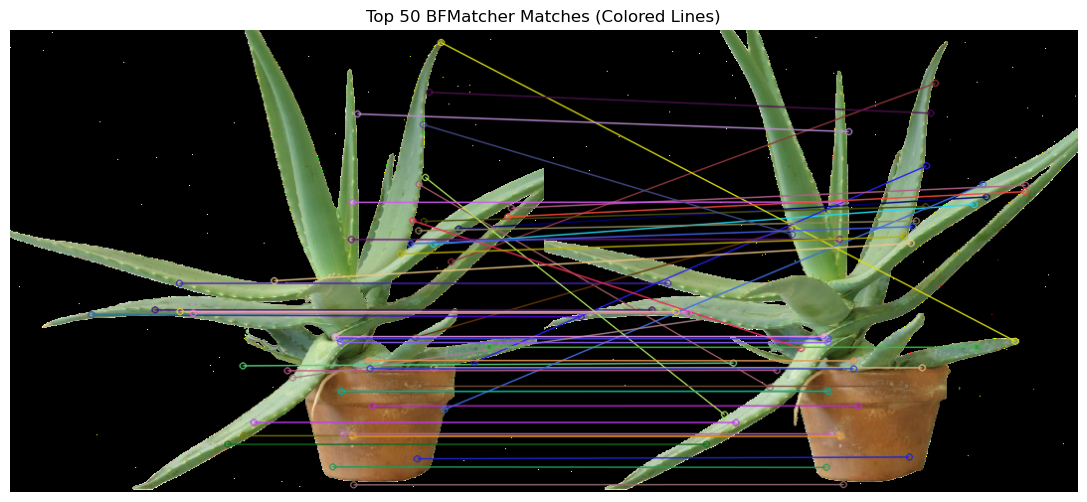

In [60]:
# Re-run SIFT on the full images to get all keypoints/descriptors
sift = cv2.SIFT_create()
kp1_all, des1_all = sift.detectAndCompute(gray1, None)
kp2_all, des2_all = sift.detectAndCompute(gray2, None)

# ---- Brute-Force Matcher ----
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
bf_matches = bf.match(des1_all, des2_all)
bf_matches = sorted(bf_matches, key=lambda x: x.distance)

# Draw top 50 matches.
# Use img1 and img2 (the original color images) to ensure colored lines/keypoints.
# The flags=2 (cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS) flag is fine.
img_bf_matches = cv2.drawMatches(img1, kp1_all, img2, kp2_all, bf_matches[:50], None, flags=2)

# Save the resulting COLOR image
cv2.imwrite('output_bf_match_color.jpg', img_bf_matches)

# Display the COLOR image using Matplotlib
# Note: We convert from OpenCV's BGR format to Matplotlib's RGB format.
plt.figure(figsize=(14,6))
plt.title('Top 50 BFMatcher Matches (Colored Lines)')
plt.imshow(cv2.cvtColor(img_bf_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

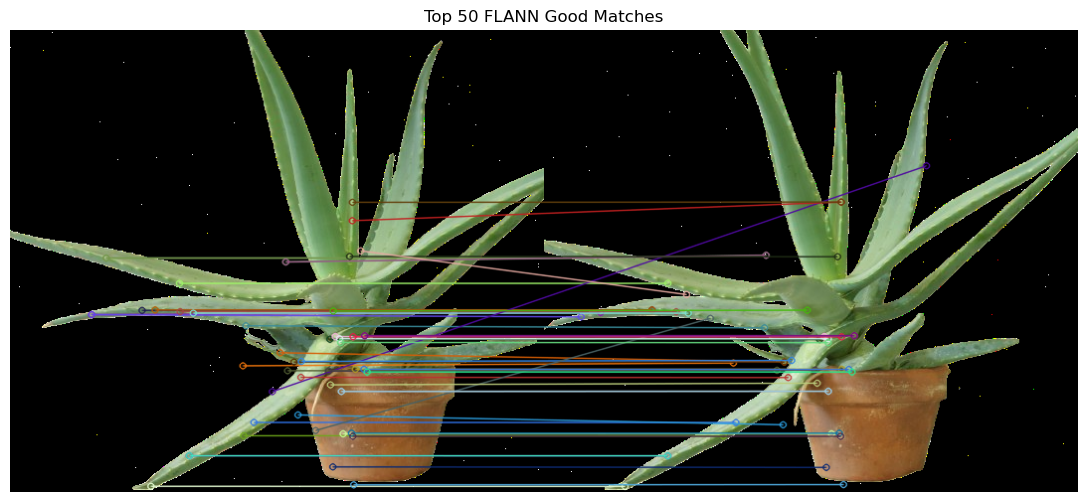

In [61]:
# ---- FLANN-based Matcher ----
FLANN_INDEX_KDTREE = 1  # SIFT uses KDTree
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Higher means more accurate, slower
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Find k=2 nearest neighbors for each descriptor
flann_matches = flann.knnMatch(des1_all, des2_all, k=2)
good_flann_matches = []
ratio_thresh = 0.75  # Standard threshold
for m, n in flann_matches:
    if m.distance < ratio_thresh * n.distance:
        good_flann_matches.append(m)

# Draw top 50 good matches
img_flann_matches = cv2.drawMatches(img1, kp1_all, img2, kp2_all, good_flann_matches[:50], None, flags=2)
cv2.imwrite('output_flann_match.jpg', img_flann_matches)
plt.figure(figsize=(14,6))
plt.title('Top 50 FLANN Good Matches')
plt.imshow(cv2.cvtColor(img_flann_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [2]:
import cv2
import numpy as np

# =======================
# Stage 3: Geometry Guru
# =======================

# 1. Load stereo images
img1 = cv2.imread('aloeL.jpg')
img2 = cv2.imread('aloeR.jpg')

if img1 is None or img2 is None:
    raise FileNotFoundError("Images not found! Check filenames or paths.")

# 2. Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 3. Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# 4. Match descriptors using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# 5. Apply Lowe’s ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

print(f"🔍 Total good matches (before RANSAC): {len(good_matches)}")

# 6. Extract point coordinates from matches
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# 7. Compute Fundamental Matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0)

# 8. Count inliers
inliers = mask.sum() if mask is not None else 0
print(f"✅ Fundamental Matrix computed successfully.")
print(f"📏 Number of inlier matches after RANSAC: {int(inliers)}")
print("\nF =\n", F)

# 9. Mini Analysis: Effect of RANSAC thresholds
for thresh in [0.5, 1.0, 5.0]:
    F_temp, mask_temp = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, thresh)
    inlier_count = mask_temp.sum()
    print(f"RANSAC threshold = {thresh:.1f} px → Inliers = {inlier_count}")


🔍 Total good matches (before RANSAC): 73
✅ Fundamental Matrix computed successfully.
📏 Number of inlier matches after RANSAC: 39

F =
 [[-6.46480631e-07 -4.96462442e-05  8.69089846e-03]
 [ 4.37043260e-05  8.97184570e-06 -1.23683369e-01]
 [-6.10587813e-03  1.16225235e-01  1.00000000e+00]]
RANSAC threshold = 0.5 px → Inliers = 34
RANSAC threshold = 1.0 px → Inliers = 39
RANSAC threshold = 5.0 px → Inliers = 54


In [63]:
import cv2
import numpy as np

# =======================
# Stage 4: Pose Explorer
# =======================

# 1. Load stereo images
img1 = cv2.imread('aloeL.jpg')
img2 = cv2.imread('aloeR.jpg')

# 2. Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 3. Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# 4. Match descriptors using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# 5. Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

print(f"Total good matches after ratio test: {len(good_matches)}")

# 6. Extract matched points
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# 7. Compute Fundamental Matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0)
inliers = int(mask.sum()) if mask is not None else 0
print(f"Inlier matches after RANSAC = {inliers}")

# Keep only inlier points
pts1_in = pts1[mask.ravel() == 1]
pts2_in = pts2[mask.ravel() == 1]

# 8. Define a simple camera intrinsic matrix K
# (Assume fx = fy = 800 pixels, and image center at half width & height)
h, w = gray1.shape
focal_length = 800
K = np.array([
    [focal_length, 0, w / 2],
    [0, focal_length, h / 2],
    [0, 0, 1]
])
print("\nIntrinsic matrix K:")
print(K)

# 9. Compute Essential Matrix: E = Kᵀ * F * K
E = K.T @ F @ K
print("\nEssential Matrix (E):")
print(E)

# 10. Recover pose (R, t) from Essential Matrix
points, R, t, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)

print("\nRecovered Rotation Matrix (R):")
print(R)
print("\nRecovered Translation Vector (t):")
print(t)

# 11. Save R and t to pose.txt
with open("pose.txt", "w") as f:
    f.write("Rotation Matrix (R):\n")
    f.write(np.array2string(R, precision=4, suppress_small=True))
    f.write("\n\nTranslation Vector (t):\n")
    f.write(np.array2string(t, precision=4, suppress_small=True))
print("\n✅ Pose saved to 'pose.txt'")


Total good matches after ratio test: 72
Inlier matches after RANSAC = 39

Intrinsic matrix K:
[[800.    0.  268.5]
 [  0.  800.  232.5]
 [  0.    0.    1. ]]

Essential Matrix (E):
[[ -0.0627977  -22.21752531   0.7512198 ]
 [ 24.53816986   1.32591171  43.84685934]
 [ -0.95155974 -45.66645764   0.07266558]]

Recovered Rotation Matrix (R):
[[ 0.99838967  0.00151555 -0.05670772]
 [-0.00224472  0.9999156  -0.01279679]
 [ 0.05668354  0.01290348  0.99830881]]

Recovered Translation Vector (t):
[[ 0.89895961]
 [-0.01467618]
 [-0.43778559]]

✅ Pose saved to 'pose.txt'



✅ Total reconstructed points: 42
🎯 Foreground points kept: 22

📍 Foreground 3D Points (first 20 shown):

[[-2.9912932  -0.05419025 13.901395  ]
 [-1.7488121   3.122091   11.001874  ]
 [-1.7222673   0.39459917 13.990611  ]
 [-1.3066      2.8965394  11.801773  ]
 [-1.3066      2.8965394  11.801773  ]
 [-0.51412994  2.658763   12.0801525 ]
 [-0.37248176  2.5515773  12.5477295 ]
 [ 0.40619016  2.0124059  13.726089  ]
 [ 0.8722059   1.8656927  13.52357   ]
 [ 1.1019424   1.4227307  13.840334  ]
 [ 1.1013379   2.246401   13.687892  ]
 [ 1.1013379   2.246401   13.687892  ]
 [ 1.3164436   3.0671482  13.884187  ]
 [ 1.3280241   1.8460425  13.550353  ]
 [ 1.4419103   1.8058338  13.249271  ]
 [ 1.494917    1.8532205  13.270358  ]
 [ 1.5339059   1.6800029  13.3980875 ]
 [ 1.5133877   1.7622256  13.00487   ]
 [ 1.6132091   2.4702575  13.544077  ]
 [ 2.4236848   2.1290529  13.507073  ]]


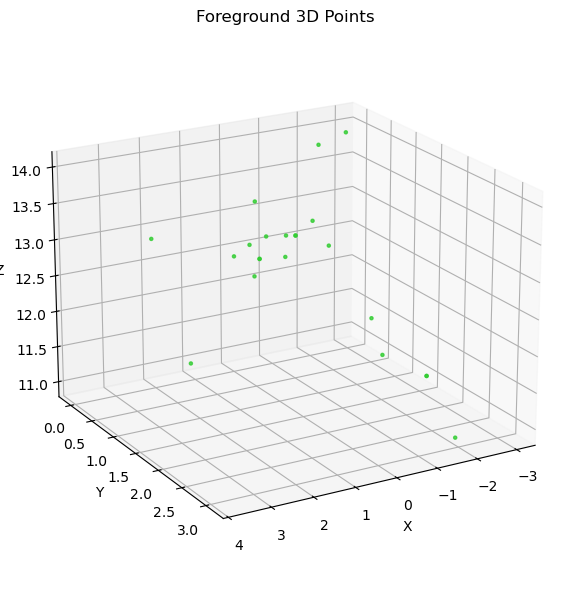


📦 Saved as 'foreground_reconstruction.png'.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =======================
# Stage 5: 3-D Builder (Foreground Only)
# =======================

# 1. Load stereo images
img1 = cv2.imread('aloeL.jpg')
img2 = cv2.imread('aloeR.jpg')

if img1 is None or img2 is None:
    raise FileNotFoundError("Images not found. Please check file names.")

# 2. Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 3. Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# 4. Match descriptors using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# 5. Apply Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# 6. Extract matched point coordinates
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# 7. Compute Fundamental Matrix with RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0)
pts1_in = pts1[mask.ravel() == 1]
pts2_in = pts2[mask.ravel() == 1]

# 8. Define simple intrinsic matrix K
h, w = gray1.shape
focal_length = 800
K = np.array([
    [focal_length, 0, w / 2],
    [0, focal_length, h / 2],
    [0, 0, 1]
])

# 9. Compute Essential Matrix
E = K.T @ F @ K

# 10. Recover pose (R, t)
_, R, t, _ = cv2.recoverPose(E, pts1_in, pts2_in, K)

# 11. Projection matrices
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

# 12. Triangulate 3D points
points_4d = cv2.triangulatePoints(P1, P2, pts1_in.T, pts2_in.T)
points_3d = (points_4d[:3] / points_4d[3]).T  # Convert from homogeneous

# 13. Keep only finite points
points_3d = points_3d[np.isfinite(points_3d).all(axis=1)]

# 14. Foreground filtering (based on depth / Z values)
z_vals = points_3d[:, 2]
z_mean = np.mean(z_vals)
foreground_points = points_3d[z_vals < z_mean]  # Keep closer (smaller Z)

print(f"\n✅ Total reconstructed points: {len(points_3d)}")
print(f"🎯 Foreground points kept: {len(foreground_points)}")
print("\n📍 Foreground 3D Points (first 20 shown):\n")
print(foreground_points[:20])

# 15. Optional plot of only foreground
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(foreground_points[:, 0], foreground_points[:, 1], foreground_points[:, 2],
           s=5, c='limegreen', alpha=0.8)
ax.set_title("Foreground 3D Points")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=20, azim=60)

plt.tight_layout()
plt.savefig("foreground_reconstruction.png", dpi=300)
plt.show()

print("\n📦 Saved as 'foreground_reconstruction.png'.")


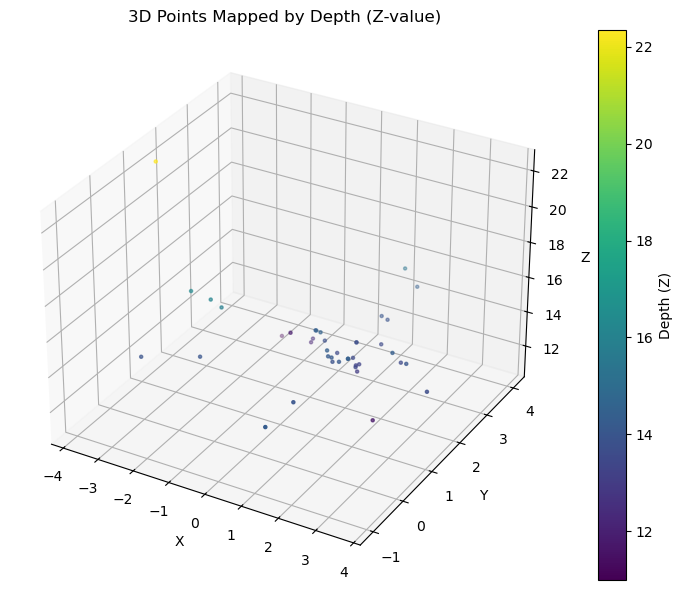

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo images
img1 = cv2.imread('aloeL.jpg')
img2 = cv2.imread('aloeR.jpg')

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# SIFT feature detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# FLANN-based feature matching
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe’s ratio test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# Extract matched points
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Compute Fundamental Matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Camera intrinsic matrix
h, w = gray1.shape
f = 800
K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]])

# Essential Matrix and Pose recovery
E = K.T @ F @ K
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

# Projection matrices
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))

# Triangulate points
points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points_3d = points_4d[:3] / points_4d[3]
points_3d = points_3d.T

# Plot with depth colorization
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
z_vals = points_3d[:, 2]
sc = ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                c=z_vals, cmap='viridis', s=5)

ax.set_title("3D Points Mapped by Depth (Z-value)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
fig.colorbar(sc, ax=ax, label="Depth (Z)")
plt.tight_layout()
plt.savefig("depth_colorized.png", dpi=300)
plt.show()
